In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.linear_model as sk
import math
from sklearn import preprocessing

# df = pd.read_csv('ks-projects-201612.csv')

    Dropping features that seem irrelevant (such as ID) or that gives some kind of repeated information (such as usd_pledfed_real, usd_goal_real and category). Also removed backers because I didn't want to make my model influenced by it (but it is an actual valid information, maybe I will try again without removing it).

In [7]:
df2018 = pd.read_csv('ks-projects-201801.csv')
df2018.drop(['ID', 'name', 'usd_pledged_real', 'usd_goal_real', 'backers', 'category'], axis=1, inplace=True)
print df2018.shape

(378661, 9)


In [8]:
label_column = 'state'
time_column = 'time_elapsed'

df2018['launched'] = pd.to_datetime(df2018['launched'])
df2018['deadline'] = pd.to_datetime(df2018['deadline'])
df2018[time_column] = (df2018.deadline - df2018.launched).astype('timedelta64[h]')
# print df2018['launched'].head(10)
# print(df2018[time_column].head(15))

df2018.drop(['launched', 'deadline'], axis=1, inplace=True)

columns = ['main_category','currency', 'state', 'country']
df2018[columns] = df2018[columns].apply(lambda x: pd.factorize(x)[0])
# df2018 = df2018.apply(lambda x: pd.factorize(x)[0])

print df2018.head()

   main_category  currency     goal  pledged  state  country  usd pledged  \
0              0         0   1000.0      0.0      0        0          0.0   
1              1         1  30000.0   2421.0      0        1        100.0   
2              1         1  45000.0    220.0      0        1        220.0   
3              2         1   5000.0      1.0      0        1          1.0   
4              1         1  19500.0   1283.0      1        1       1283.0   

   time_elapsed  
0        1403.0  
1        1435.0  
2        1079.0  
3         716.0  
4        1335.0  


In [11]:
# Normalizing data
df2018.dropna(inplace=True)
x = df2018.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2018 = pd.DataFrame(x_scaled)

print df2018.head()

          0         1         2             3    4         5             6  \
0  0.000000  0.000000  0.000010  0.000000e+00  0.0  0.000000  0.000000e+00   
1  0.071429  0.076923  0.000300  1.190325e-04  0.0  0.045455  4.916666e-06   
2  0.071429  0.076923  0.000450  1.081666e-05  0.0  0.045455  1.081666e-05   
3  0.142857  0.076923  0.000050  4.916666e-08  0.0  0.045455  4.916666e-08   
4  0.071429  0.076923  0.000195  6.308082e-05  0.2  0.045455  6.308082e-05   

          7  
0  0.003492  
1  0.003572  
2  0.002686  
3  0.001782  
4  0.003323  


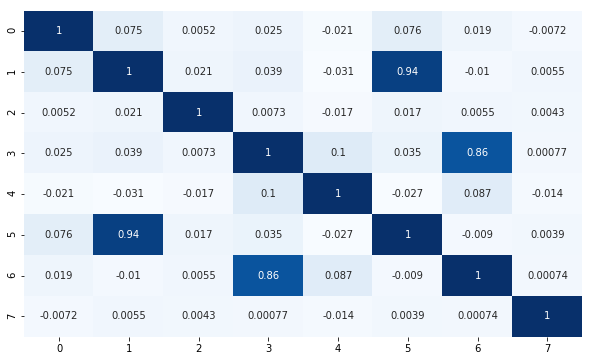

In [12]:
corr = df2018.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cbar=None, annot=True, cmap='Blues')
# sns.pairplot(df2018, hue=label_column)
plt.show()

In [13]:
print "plot scatter"
pd.plotting.scatter_matrix(df2018, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

plot scatter


KeyboardInterrupt: 

    First, let's try using a linear model.

In [14]:
X = np.array(df2018.drop([label_column], axis=1))
# y = df2018[label_column].shift(-shift_param)
y = df2018[label_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89, shuffle=True)

print "Starting..."

# clf = LinearRegression()
clf = sk.LogisticRegression()
clf.fit(X_train, y_train)

print "Finished!"

print clf.score(X_test, y_test)

ValueError: labels ['state'] not contained in axis

In [12]:
print len(X)

378661


    What I tried to do next was to separate some data to test the model with information that it (the model) had never seen so we can attest for its generalization.

In [14]:
# X = preprocessing.scale(X)

shift_param = int(math.ceil(len(X)*0.1))
X_predict = X[~shift_param:]
y_predict = y[~shift_param:]
X = X[:~shift_param+1]
y = y[:~shift_param+1]

#Again slicing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89, shuffle=True)
clf.fit(X_train, y_train)

print clf.score(X_test, y_test)

0.665796153113


In [15]:
print len(X)

340794


In [17]:
y_predictions = clf.predict(X_predict)

print clf.score(X_predict, y_predict)

0.677590577797


    Now, let's try using a non-linear model to see how we can have better conclusions about our data.

In [19]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 0.652596089301


In [21]:
my_predictions = my_model.predict(X_predict)
print("Mean Absolute Error : " + str(mean_absolute_error(my_predictions, y_predict)))

Mean Absolute Error : 0.638028605985


In [23]:
from sklearn.neural_network import MLPClassifier

newClf = MLPClassifier(alpha=1)

newClf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [25]:
score = newClf.score(X_test, y_test)
print score

0.668451708505


In [26]:
clfSVM = svm.NuSVC()
clfSVM.fit(X_train, y_train)

ValueError: specified nu is infeasible